In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import meteva.base as meb
import meteva.method as mem
import meteva.product as mpd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pandas as pd

本模块的函数族旨在快速绘制误差的空间分布情况。在浏览本模块函数说明之前可先参阅函数设计的[关键技术思想](https://www.showdoc.cc/meteva?page_id=4072178802924517)。本模块包含数值型检验指标的计算方法，为对其进行介绍，以下先对测试数据进行一个简单的介绍。

### 测试数据集：  
 **数据范围** ： 为了减少测试数据量又说明问题，仅截取了110 - 120°E， 25 -35°N范围内的观测和预报数据。  
 **观测数据** ： 2020年3月23日至26日2m温度观测数据，时间间隔3小时  
 **预报数据** ：  
    **ECMWF：** 2020年3月23日08时至23日08时的0至72小时时效2m温度预报数据，起报时间间隔为12小时，预报时效间隔为3小时  
    **GRAPES_GFS：** 2020年3月23日08时至23日08时的0至72小时时效2m温度预报数据，起报时间间隔为12小时，预报时效间隔为3小时  


In [2]:
###################以下开始为数据收集部分的程序

#设置关注的起始时段
time_start = datetime.datetime(2020,3,20,8,0)   
time_end = datetime.datetime(2020,3,27,8,0)
#读取站点列表，并将站点内容为缺省值，当其作为读取站点数据的参数时，如果站点文件中某个站号不存在时,返回结果中该站点保持为缺省值
station = meb.read_stadata_from_micaps3(r"H:\test_data\input\mpd\ob\temp_2m_br\20032008.000")
station.iloc[:,-1] = meb.IV 


##读取收集观测数据
dir_ob = r"H:\test_data\input\mpd\ob\temp_2m_br\YYMMDDHH.000"
sta_list = []
time0 = time_start
while time0 < time_end:
    path = meb.get_path(dir_ob,time0)
    sta = meb.read_stadata_from_micaps3(path,station = station,time = time0,dtime = 0,level = 0,data_name = "ob")
    sta_list.append(sta)
    time0 += datetime.timedelta(hours = 3)
ob_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
ob_sta_all = meb.sele_by_para(ob_sta_all,value=[-100,100]) #简单的质量控制


time_end = datetime.datetime(2020,3,23,8,0)
#读取收集ec预报数据
dir_ec = r"H:\test_data\input\mpd\ec\temp_2m_br\YYMMDDHH.TTT.nc"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_ec,time0,dh)
        grd = meb.read_griddata_from_nc(path,time = time0,dtime = dh,level = 0,data_name = "ecmwf")
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            sta_list.append(sta)
    time0 += datetime.timedelta(hours = 12)  
ec_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
            
#读取收集grapes预报数据
dir_grapes = r"H:\test_data\input\mpd\grapes\temp_2m_br\YYMMDDHH.TTT.nc"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_grapes,time0,dh)
        grd = meb.read_griddata_from_nc(path,time = time0,dtime = dh,level = 0,data_name = "grapes")
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            sta_list.append(sta)  
    time0 += datetime.timedelta(hours = 12)
grapes_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
    
#数据匹配合并
sta_all = meb.combine_on_obTime_id(ob_sta_all,[ec_sta_all,grapes_sta_all])
sta_all = meb.sele_by_para(sta_all,drop_IV = True)  #删除包含缺省值的样本
###################以上为数据收集部分的程序

# 误差站点分布图   
**me_scatter(sta_ob_and_fos,s = None,g = None,gll = None,save_dir=None,show = False, print_max = 1,title="均方根误差站点分布"):**  
根据输入的站点数据，选择部分数据，误差站点分布图  


# 绝对误差站点分布图 
**mae_scatterr(sta_ob_and_fos,s = None,g = None,gll = None,save_dir=None,show = False, print_max = 1,title="均方根误差站点分布"):**  
根据输入的站点数据，选择部分数据，误差站点分布图 

# 均方根误差站点分布图 
**mae_scatterr(sta_ob_and_fos,s = None,g = None,gll = None,save_dir=None,show = False, print_max = 1,title="均方根误差站点分布"):**  
根据输入的站点数据，选择部分数据，误差站点分布图 


|参数|说明（上述两个函数参数意义和用法完全相同）|  
|:--|:--|  
|**sta_ob_and_fos**|实况和预报合并对齐后的数据，形式为站点数据格式如上述例子中的sta_all|             
|**s**| 用于选择数据样本的字典参数，具体的参数说明可参见meb.sele_by_dict中的[<font face="黑体" color=red size=5>s</font>](https://www.showdoc.cc/meteva?page_id=3975604785954540)参数  |   
|**g**|用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>g</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|     
|**gll**| 用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>gll</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|  
|**group_name_list**| 指定分组的名称，它将在图片标题中体现  
|**save_dir**| 图片输出文件夹，文件的路径将据此自动生成|  
|**show**| 是否在屏幕显示图片，如果save_dir 为None时，程序内部会自动将show设置True|  
|**print_max**| 在平面上打印误差绝对值排名前print_max的站点的信息|  
|**title**|指定图片标题|  
|<font face="黑体" color=blue size=3>return</font>|无返回值|  
  
**调用示例：**

误差绝对值前1的站点：
id:57359   lon:110.73  lat:31.35 value:-6.288272


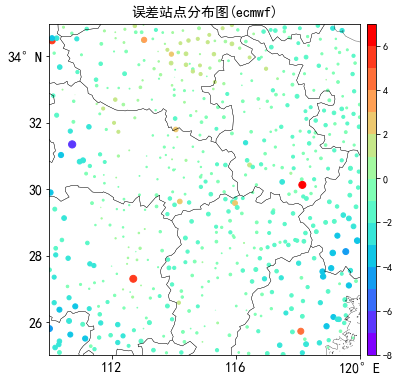

误差绝对值前1的站点：
id:57355   lon:110.37  lat:31.03 value:-6.654348


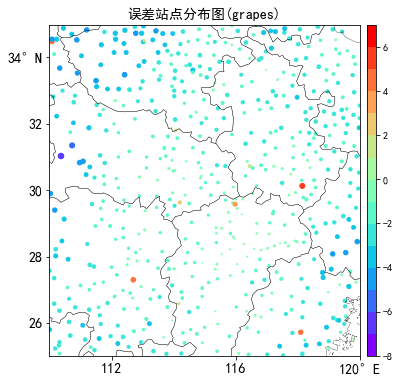

In [11]:
mpd.me_scatter(sta_all)  #对所有的样本进行分析，对于一个站点而言，不同起报时间和预报时效的样本被放在一起考了

在上述分析中默认print_max = True, 因此会自动打印哪个站点的误差绝对值最大。这样方便快对有问题的预报进行更详细的研究。比如上面的例子中我们看到湖北西部、湖南中部和安徽南部有几个温度预报偏差比较大的点。但是自动打印的只有一个站点，如果想知道湖南中部那个异常点的站号，可以通过设置print_max来解决。

误差绝对值前4的站点：
id:57359   lon:110.73  lat:31.35 value:-6.288272
id:58437   lon:118.15  lat:30.13 value:6.026918
id:57776   lon:112.7  lat:27.3 value:5.816475
id:57046   lon:110.08  lat:34.48 value:5.2647533


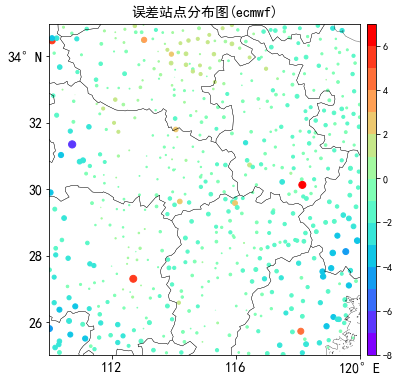

In [12]:
#仅对ecmwf的预报进行分析，且为了锁定湖南南部异常点，将分析范围进行缩小
mpd.me_scatter(sta_all,s = {"member":["ob","ecmwf"]},print_max = 4)  

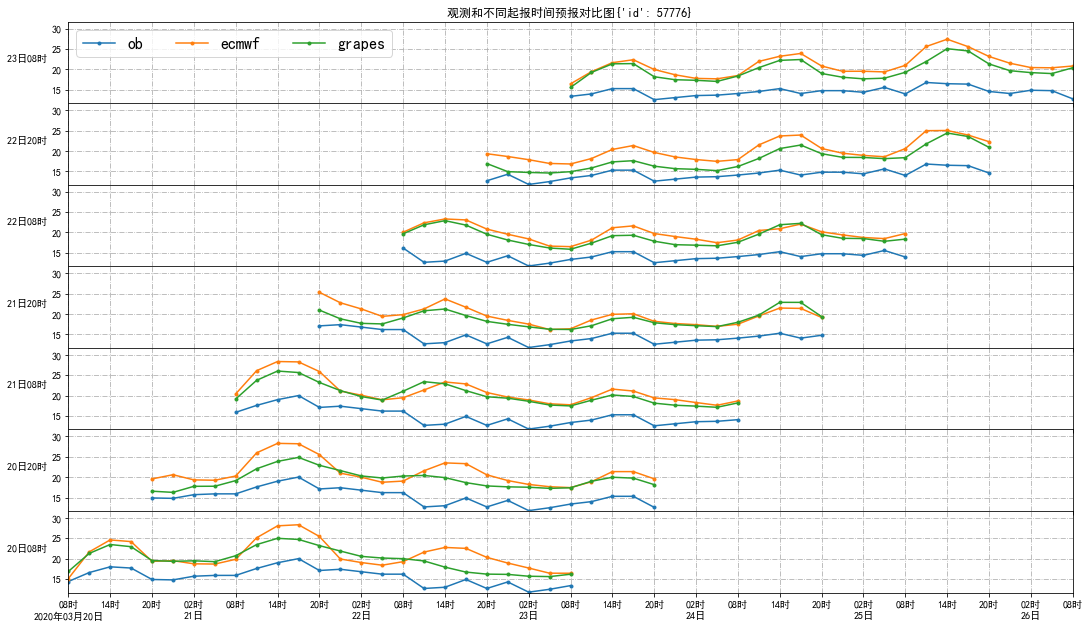

In [13]:
#通过上面的信息，可锁定湖南中部的误差较大点的站号是57776，如果需要对它展开分析，则可以进行一步采用时序分析的函数进行
mpd.time_list_line(sta_all,s={"id":57776})

误差绝对值前1的站点：
id:57596   lon:114.2  lat:29.63 value:2.095925


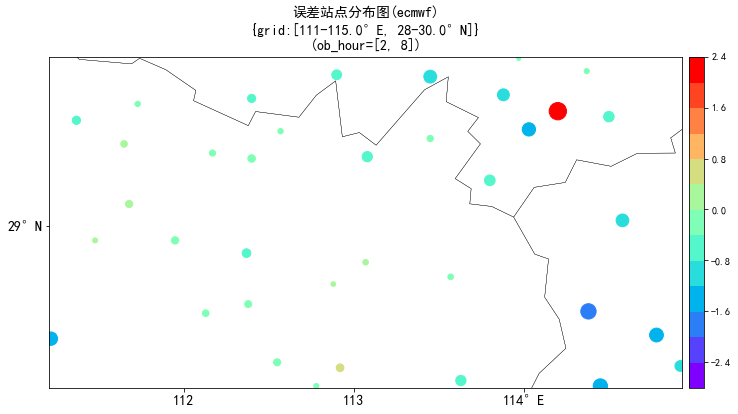

误差绝对值前1的站点：
id:57596   lon:114.2  lat:29.63 value:2.8527217


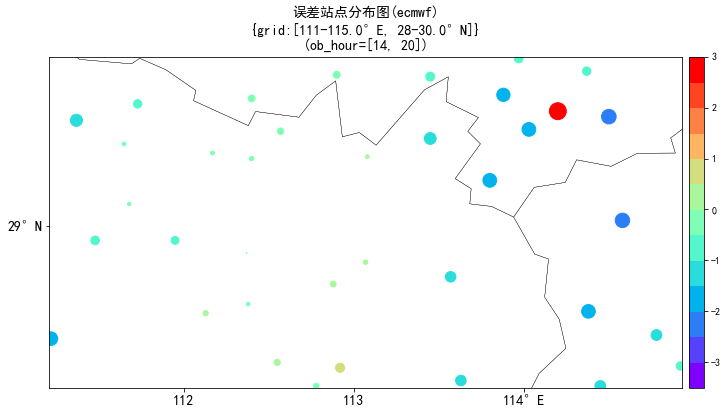

In [14]:
grid =meb.grid([111,115,0.5],[28,30,0.5]) #选取部分数据，进行分组检验
mpd.me_scatter(sta_all,s = {"grid":grid,"member":["ob","ecmwf"]},g = "ob_hour",gll = [[2,8],[14,20]])

误差绝对值前1的站点：
id:57694   lon:114.38  lat:28.53 value:2.7374716


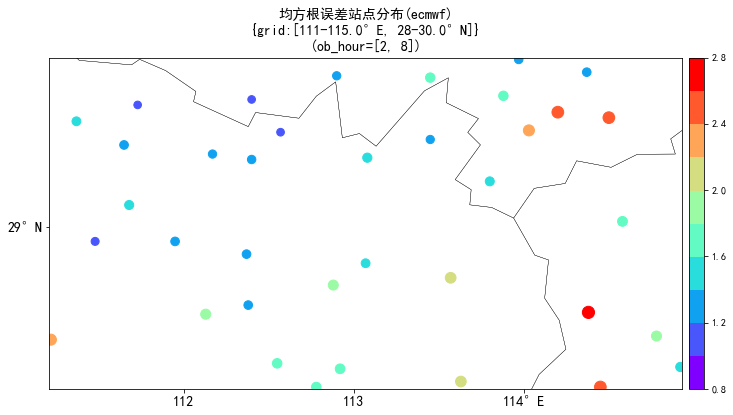

误差绝对值前1的站点：
id:57596   lon:114.2  lat:29.63 value:4.0014453


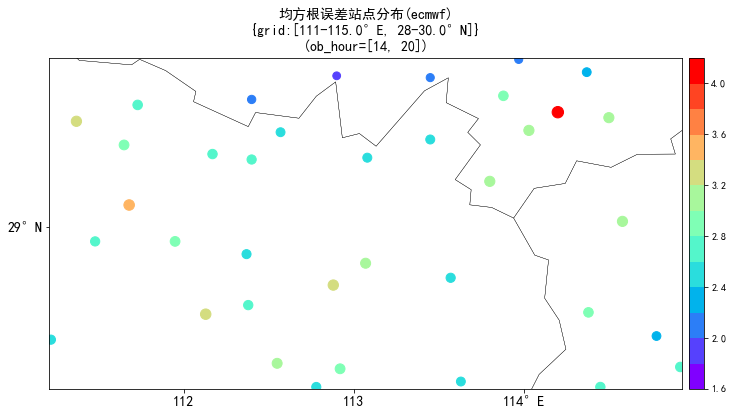

In [18]:
mpd.rmse_scatter(sta_all,s = {"grid":grid,"member":["ob","ecmwf"]},g = "ob_hour",gll = [[2,8],[14,20]])

In [ ]:
mpd.me_scatter(sta_all,s = {"member":["ob","ecmwf"]}) #对所有的样本进行分析，对于一个站点而言，不同起报时间和预报时效的样本被放在一起考了